In [45]:
from infer import load_model
from metrics import compute_metrics
from shared import (
    ACCURACY, PRECISION, RECALL, F1_SCORE, IOU,
    VALIDATION, TEST, TRAIN,
    DEVICE, DISTILLATION
)
import torch
import pandas as pd
from pathlib import Path
%load_ext autoreload
%autoreload 2
device = DEVICE
from quantization import get_array_size_in_bytes, dequantize_weights, dequantize_weights_per_layer
from model_quantization import quantize_model_per_layer
from evaluate import evaluate_model, evaluate_test_mode, visualize_performance_per_well, get_global_metrics_str, compare_performance_per_well

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
# exp_list = [53, 1004]
exp_list = [1004]
checkpoint = 'best_model'

In [49]:
results_dict = {}
for exp in exp_list:
    for quantization_num_bits in [None, 8]:
        model, dl_dict, model_config = load_model(exp, batch_size=16, model_name=checkpoint+".pt")
        if quantization_num_bits is not None:
            print("Quantizing model...")
            params = torch.cat([p.flatten() for p in model.parameters() if p.requires_grad])
            params = params.detach().cpu().numpy()
            quantized_weights, quantization_parameters = quantize_model_per_layer(model, num_bits=quantization_num_bits)
            params_dequant = dequantize_weights_per_layer(quantized_weights, quantization_parameters)
            for name, param in model.named_parameters():
                if name in params_dequant:
                    param.data = torch.nn.Parameter(torch.from_numpy(params_dequant[name])).to(device=device)
                    print(name, "has been updated with quantized weights")
        metrics_validation, detailed_metrics_validation = evaluate_model(model, dl_dict, phase=VALIDATION, detailed_metrics_flag=True)
        metrics_train, detailed_metrics_train =evaluate_model(model, dl_dict, phase=TRAIN, detailed_metrics_flag=True)
        df_train = pd.DataFrame(detailed_metrics_train)
        df_validation = pd.DataFrame(detailed_metrics_validation)
        model_name = model_config['model']['name'] + ' - ' + str(exp) + " " + checkpoint
        model_name += f" - quantized {quantization_num_bits}" if quantization_num_bits is not None else ""
        results_dict[f"{exp:04d}" + (f"_quantized {quantization_num_bits}" if quantization_num_bits is not None else "")] = (metrics_validation, detailed_metrics_validation, metrics_train, detailed_metrics_train, model_config, df_train, df_validation, model_name)



TOTAL ELEMENTS 7737
TOTAL ELEMENTS 1935
TOTAL ELEMENTS 2538


100%|██████████| 121/121 [00:04<00:00, 28.23it/s]


Metrics on validation set
{'accuracy': 0.9750799536705017, 'precision': 0.8122709393501282, 'recall': 0.8545907139778137, 'dice': 0.7893723845481873, 'iou': 0.7154967784881592}


100%|██████████| 484/484 [00:18<00:00, 26.25it/s]


Metrics on train set
{'accuracy': 0.9769202470779419, 'precision': 0.8295949697494507, 'recall': 0.8614419102668762, 'dice': 0.8057383894920349, 'iou': 0.7301884889602661}
TOTAL ELEMENTS 7737
TOTAL ELEMENTS 1935
TOTAL ELEMENTS 2538
0.55 Mb
2.20 Mb
compression ratio = 4.004
encoder_list.0.conv_block.conv_stage.0.conv.weight has been updated with quantized weights
encoder_list.0.conv_block.conv_stage.1.conv.weight has been updated with quantized weights
encoder_list.1.conv_block.conv_stage.0.conv.weight has been updated with quantized weights
encoder_list.2.conv_block.conv_stage.0.conv.weight has been updated with quantized weights
decoder_list.0.conv_block.conv_stage.0.conv.weight has been updated with quantized weights
decoder_list.1.conv_block.conv_stage.0.conv.weight has been updated with quantized weights
decoder_list.2.conv_block.conv_stage.0.conv.weight has been updated with quantized weights
decoder_list.2.conv_block.conv_stage.1.conv.weight has been updated with quantized weight

100%|██████████| 121/121 [00:04<00:00, 25.02it/s]


Metrics on validation set
{'accuracy': 0.9750775098800659, 'precision': 0.8139001131057739, 'recall': 0.8537893891334534, 'dice': 0.7895625233650208, 'iou': 0.7158442139625549}


100%|██████████| 484/484 [00:18<00:00, 25.98it/s]

Metrics on train set
{'accuracy': 0.9769366383552551, 'precision': 0.8303963541984558, 'recall': 0.8607764840126038, 'dice': 0.805854856967926, 'iou': 0.730309009552002}


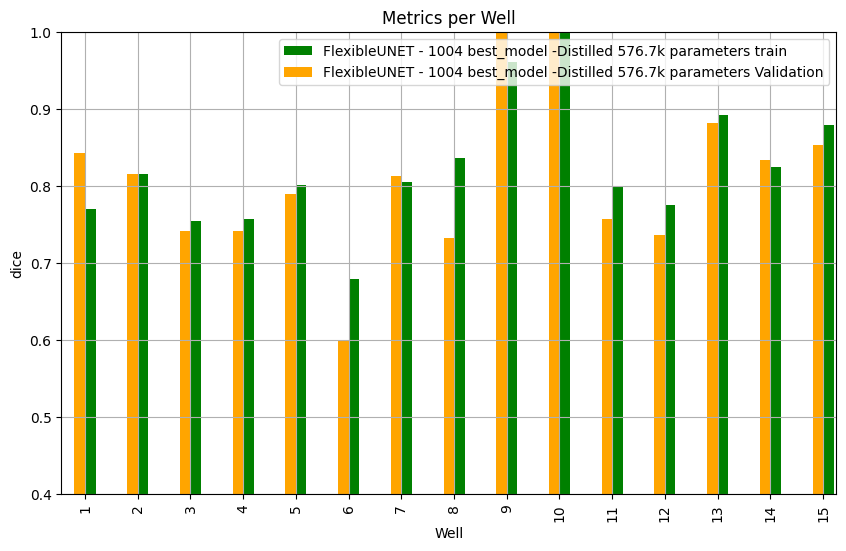

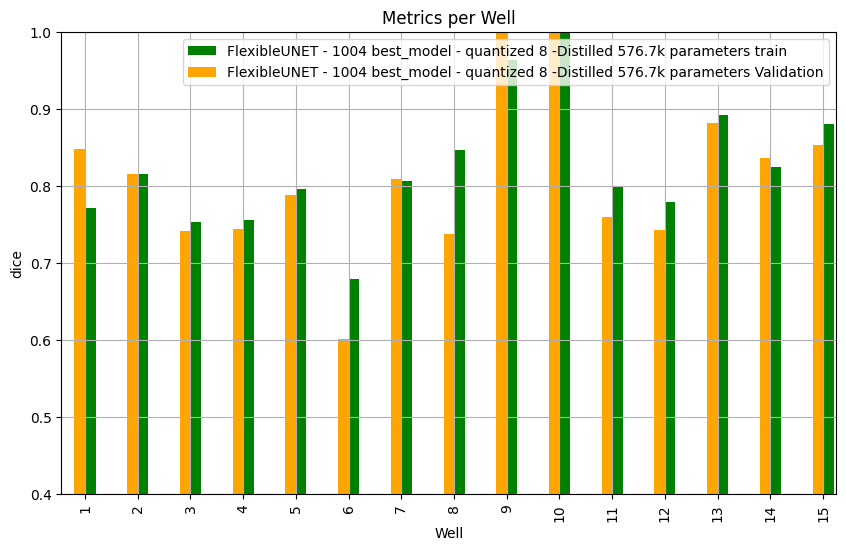

In [50]:
selected_exp_list = [f"{exp:04d}" for exp in exp_list]
chosen_metric = F1_SCORE
selected_exp_list = list(results_dict.keys())
for exp in selected_exp_list:
    list_df_plot = []
    label_list = []
    metrics_validation, detailed_metrics_validation, metrics_train, detailed_metrics_train, model_config, df_train, df_validation, model_name = results_dict[exp]
    list_df_plot.append(df_train)
    label_list.append(model_name + (' -Distilled' if model_config.get(DISTILLATION, False) else "") + f' {model_config["model"]["n_params"]/1000:.1f}k parameters'+ " train")
    list_df_plot.append(df_validation)
    label_list.append(model_name + (' -Distilled' if model_config.get(DISTILLATION, False) else "") + f' {model_config["model"]["n_params"]/1000:.1f}k parameters'+ " Validation")
    compare_performance_per_well(list_df_plot, label_list=label_list, chosen_metric=chosen_metric)

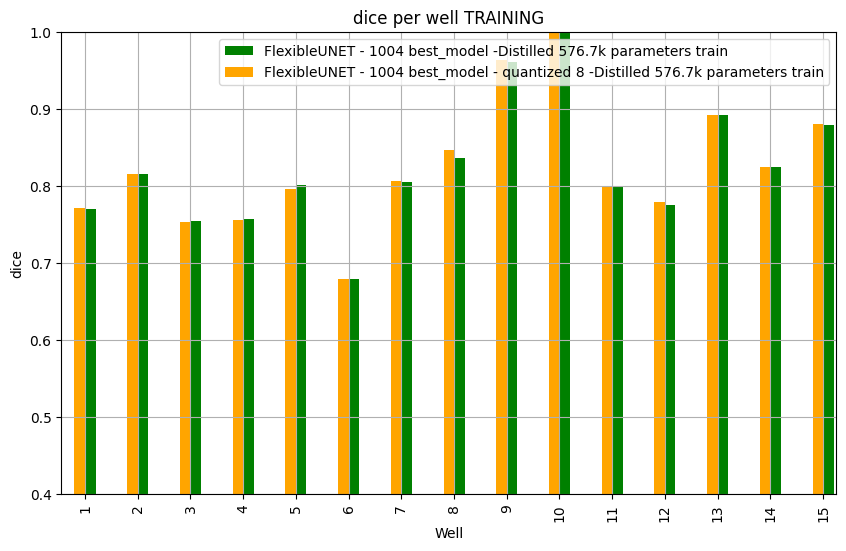

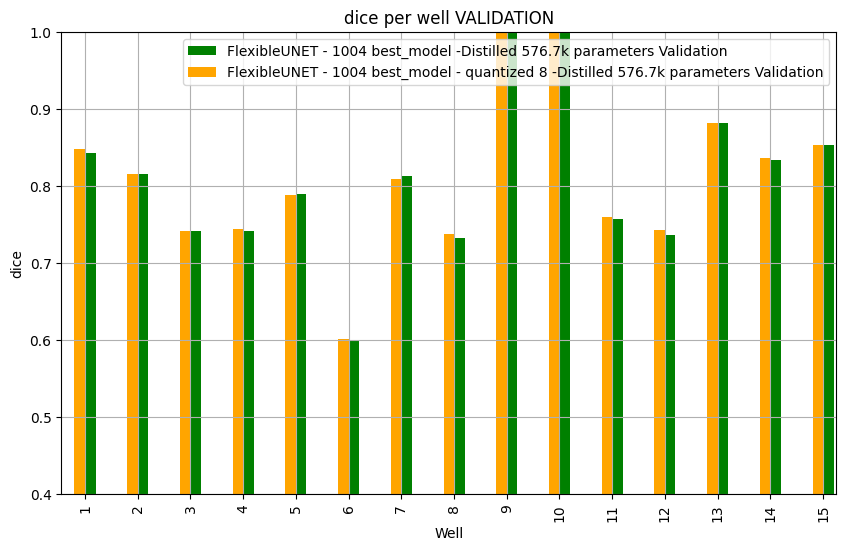

In [55]:
list_df_plot = []
label_list = []
for exp in selected_exp_list:
    metrics_validation, detailed_metrics_validation, metrics_train, detailed_metrics_train, model_config, df_train, df_validation, model_name = results_dict[exp]
    list_df_plot.append(df_train)
    label_list.append(
        model_name + (' -Distilled' if model_config.get(DISTILLATION, False) else "") + f' {model_config["model"]["n_params"]/1000:.1f}k parameters'+ " train",
    )
compare_performance_per_well(list_df_plot, label_list=label_list,  title=f"{chosen_metric} per well TRAINING", chosen_metric=chosen_metric)

list_df_plot = []
label_list = []
for exp in selected_exp_list:
    metrics_validation, detailed_metrics_validation, metrics_train, detailed_metrics_train, model_config, df_train, df_validation, model_name = results_dict[exp]
    list_df_plot.append(df_validation)
    label_list.append(
        model_name + (' -Distilled' if model_config.get(DISTILLATION, False) else "") + f' {model_config["model"]["n_params"]/1000:.1f}k parameters'+ " Validation",
    )
compare_performance_per_well(list_df_plot, label_list=label_list, title=f"{chosen_metric} per well VALIDATION", chosen_metric=chosen_metric)

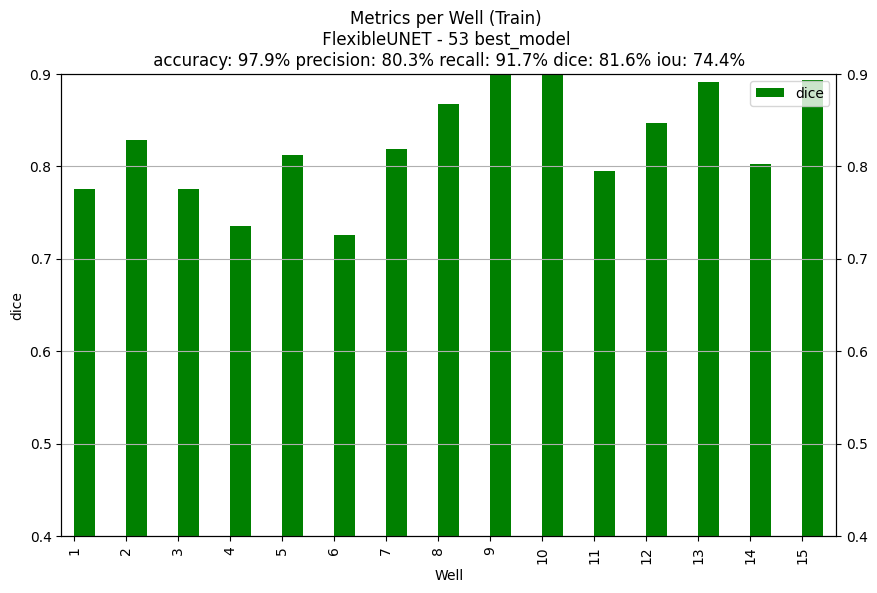

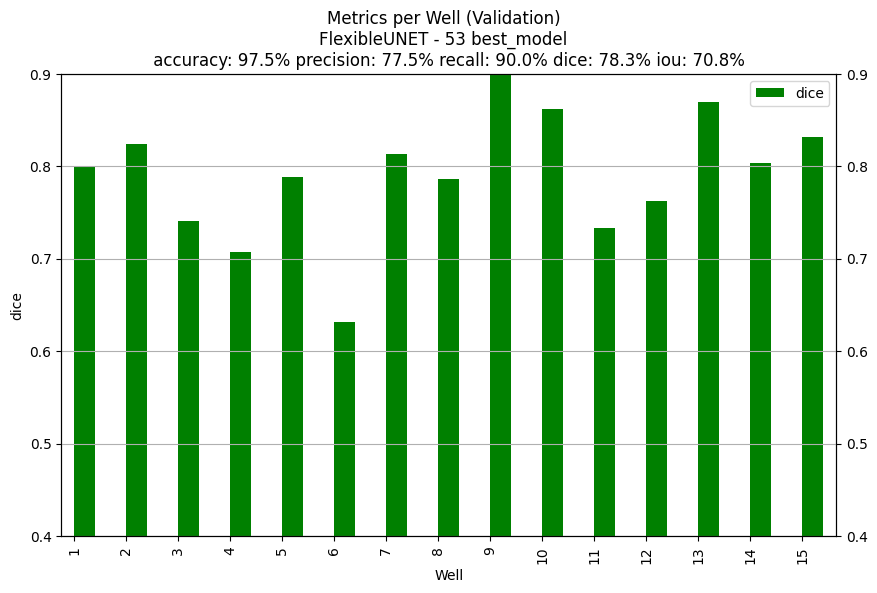

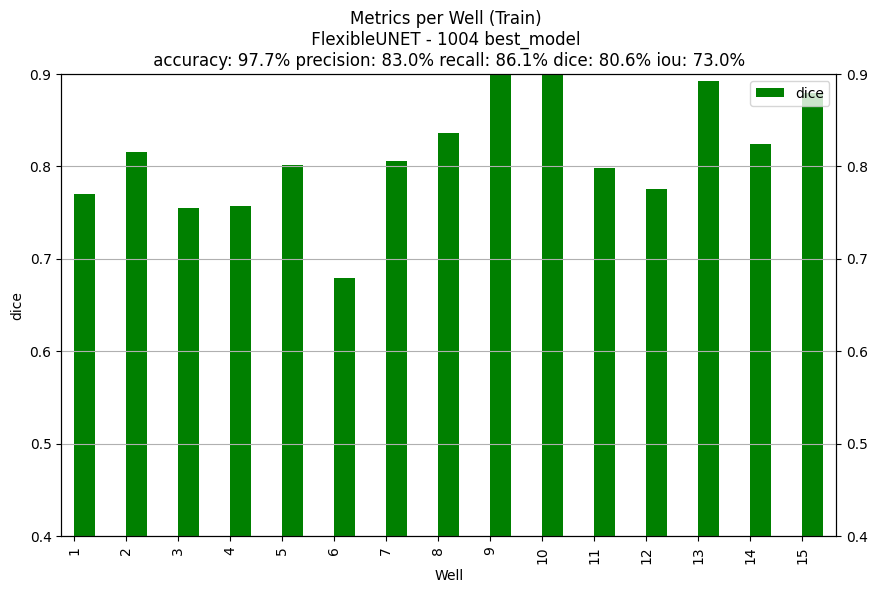

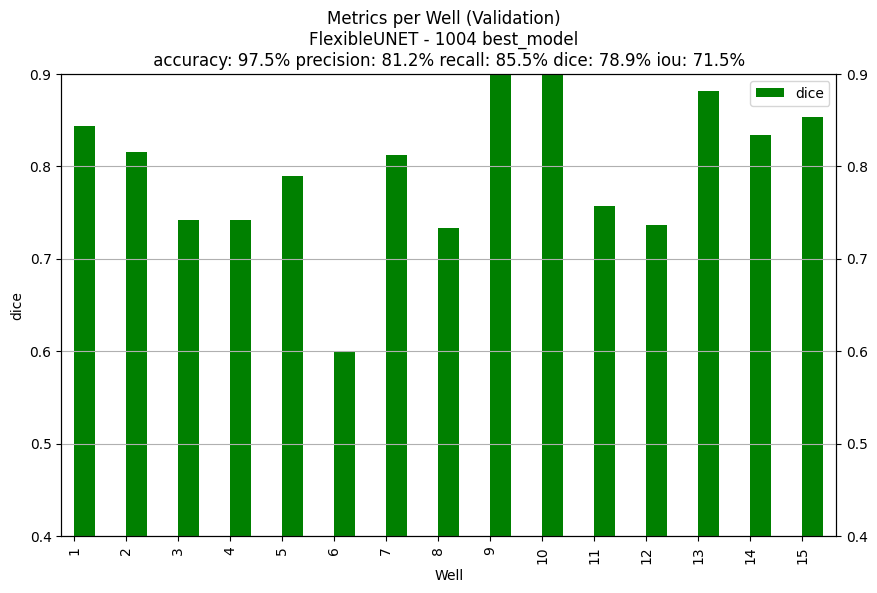

In [5]:
chosen_metrics=[F1_SCORE,]
# chosen_metrics = [PRECISION, RECALL]
for exp in exp_list:
    metrics_validation, detailed_metrics_validation, metrics_train, detailed_metrics_train, model_config, df_train, df_validation, model_name = results_dict[exp]
    visualize_performance_per_well(df_train, chosen_metrics=chosen_metrics, title=f'Metrics per Well (Train) \n {model_name}  \n {get_global_metrics_str(metrics_train)}')
    visualize_performance_per_well(df_validation, chosen_metrics=chosen_metrics, title=f'Metrics per Well (Validation)  \n{model_name}  \n {get_global_metrics_str(metrics_validation)}')
### -> Test 1 3 4 5


In [ ]:
# Export submission for test set https://challengedata.ens.fr/participants/challenges/144/
for exp in exp_list:
    model, dl_dict, model_config = load_model(exp, batch_size=16, model_name=checkpoint+".pt")
    labeled_dict = evaluate_test_mode(model, dl_dict, save_path=Path(f'__submission_{exp:04d}_dataset_update.csv'))